In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

In [240]:
# from google.colab import drive
# drive.mount('/content/drive')

## 이번에는 영화 리뷰를 기반으로 감성 분석을 진행해볼 것이다
 사용되어질 데이터는 IMDB 데이터셋으로 train 2.5만개, test 2.5만개로 구성되어 있으며 긍적적인 리뷰와 부정적인 리뷰의 수는 동일하도록 구성되어 있다.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file('aclIndb_v1', url, untar =True, cache_dir = '.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 3s 0us/step


In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'test', 'README', 'imdbEr.txt']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

os.listdir(train_dir), os.listdir(test_dir)

(['urls_neg.txt',
  'neg',
  'pos',
  'unsupBow.feat',
  'urls_unsup.txt',
  'urls_pos.txt',
  'unsup',
  'labeledBow.feat'],
 ['urls_neg.txt', 'neg', 'pos', 'urls_pos.txt', 'labeledBow.feat'])

In [5]:

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())
print(len(os.listdir(os.path.join(train_dir, 'pos'))))

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.
12500


In [6]:
# 사용하지 않을 데이터를 날린다.
remove_dir = os.path.join(train_dir, 'unsup')
# 아래의 코드는 폴더안에 파일이 있으면 사용할 수 없다.
# os.rmdir(remove_dir)
shutil.rmtree(remove_dir)

In [7]:
# 디렉토리의 텍스트 데이터를 폴더에 따라 분류하여 데이터셋으로 만든다. 
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                          batch_size=batch_size,
                                                          validation_split=0.2,
                                                          subset='training',
                                                          seed = seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                          batch_size=batch_size,
                                                          validation_split=0.2,
                                                          subset='validation',
                                                          seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
# 테스트 데이터 로드
raw_test_ds = tf.keras.utils.text_dataset_from_directory(test_dir,
                                                         batch_size= batch_size)

Found 25000 files belonging to 2 classes.


In [9]:
# 데이터 로드가 잘 되었는지 확인해본다.
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('review', text_batch.numpy()[i])
    print('label', label_batch.numpy()[i])

review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
# 위에 표시된 라벨의 0,1 값이 각각 무엇인지 확인해본다.
print('label 0 means -', raw_train_ds.class_names[0])
print('label 1 means -', raw_train_ds.class_names[1])

label 0 means - neg
label 1 means - pos


In [11]:
# 여기서 더 커스터마이징을 진행하지 않는다면 아래의 TextVectorization의 파라미터 standardize = 'lower_and_strip_punctuation' 넣는것과 동일하다
def custom_standardization(input_data):
    # 단어를 모두 소문자로 변경한다.
    lowercase = tf.strings.lower(input_data)
    # 위의 프린트값에도 남아있던 html관련 문구를 지운다.
    stripped_html = tf.strings.regex_replace(lowercase, '<br />',' ')
    return tf.strings.regex_replace(stripped_html,
                                  f'[{re.escape(string.punctuation)}]', # 구두점과 같은 기호를 지워준다.
                                  '')

In [12]:
# 위의 punctuation 함수의 효과확인해보기
s = "Alice (2252), Responses (3rd), 2018 Cens - 2.5% Sample"
out = re.sub(f'[{re.escape(string.punctuation)}]', '', s)
print(out)

Alice 2252 Responses 3rd 2018 Cens  25 Sample


In [13]:

max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize = custom_standardization,
    # 단어의 최대수를 제한 ovv(out of vocavulary)가 포함되어있어 max_features-1 개 어휘
    max_tokens = max_features,
    output_mode = 'int',
    # 발생한 토큰의 수와 관계없이 (batch_size, output_sequence_length)가 생성 
    output_sequence_length = sequence_length
)

In [14]:
# 라벨을 제외한 데이터셋을 만든후 adapt에 넣는다.
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [ ]:
# k =np.array([[1,2,3],[4,5,6]])
# print(k.shape)
# tf.expand_dims(k,-1)

In [15]:
# 전처리된 결과를 확인하기 위함 함수를 만들어 준다.
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('review', first_review)
print('label', raw_train_ds.class_names[first_label])
print('vectorized review', vectorize_text(first_review, first_label))

review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
label neg
vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [17]:
print(vectorize_layer.get_vocabulary()[1300])

presence


In [18]:
# 벡터화 함수를 데이터셋에 적용한다.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:

autotune = tf.data.AUTOTUNE
# .cache()데이터가 디스크에서 로드된 후 메모리에 데이터를 보관합니다
# .prefetch()학습하는 동안 데이터 전처리 및 모델 실행이 겹칩니다.
train_ds = train_ds.cache().prefetch(buffer_size = autotune)
val_ds = val_ds.cache().prefetch(buffer_size = autotune)
test_ds = test_ds.cache().prefetch(buffer_size = autotune)

In [20]:
embedding_dim = 16

model = tf.keras.Sequential([
    # max_features 의 depth가 16인 벡터로 변경
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    # 1
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

In [22]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)


Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6643 - binary_accuracy: 0.6949 - val_loss: 0.6146 - val_binary_accuracy: 0.7712
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5480 - binary_accuracy: 0.8025 - val_loss: 0.4976 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4441 - binary_accuracy: 0.8444 - val_loss: 0.4196 - val_binary_accuracy: 0.8480
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3780 - binary_accuracy: 0.8643 - val_loss: 0.3735 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3356 - binary_accuracy: 0.8788 - val_loss: 0.3451 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3050 - binary_accuracy: 0.8891 - val_loss: 0.3259 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

In [23]:
loss, accuracy = model.evaluate(test_ds)
print('loss : ',loss)
print('accuracy: ',accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3105 - binary_accuracy: 0.8730
loss :  0.31052660942077637
accuracy:  0.8730400204658508


In [24]:
# 학습과정에 대한 데이터를 가져오고 아래에서 그래프를 그려보겠다.
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

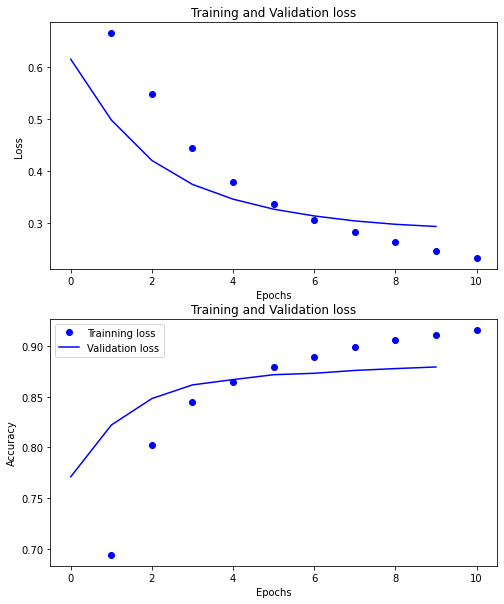

In [38]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.plot(range(1,len(acc)+1),loss,'bo',label='Trainning loss')
plt.plot(range(0,len(acc)), val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)

plt.title('Training and Validation loss')
plt.plot(range(1,len(acc)+1),acc,'bo',label='Trainning loss')
plt.plot(range(0,len(acc)), val_acc,'b',label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 모델 내보내기


In [40]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss = tf.losses.BinaryCrossentropy(from_logits=False), optimizer = 'adam', metrics = ['accuracy']
)



In [41]:
# 잘 작동하는지 테스트
export_model.evaluate(raw_test_ds)

782/782 [==============================] - 4s 5ms/step - loss: 0.3105 - accuracy: 0.8730


[0.3105265498161316, 0.8730400204658508]

In [42]:
# 새로운 데이터가 잘 되는지 평가
ex = [
    'That was Good!',
    'not bad',
    'bad'
]

export_model.predict(ex)

1/1 [==============================] - 0s 114ms/step


array([[0.50666046],
       [0.32790172],
       [0.35370544]], dtype=float32)